In [1]:
# import dependencies
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

### Merge & Prepare Datasets

In [2]:
# read in previously collected data
schools = pd.read_csv("Data/fbsSchoolData.csv") # season, team, id, mascot, abbrev, conference, division
playCalls = pd.read_csv("Data/fbsPlayCallData_noGT.csv") # season, team, conference, totalPlays, passingPlays, rushingPlays
winLoss = pd.read_csv("Data/fbsWinLossData.csv") # season, team, id, mascot, abbrev, conference, division, games, wins, losses, ties

# merge datasets together
merge_1 = pd.merge(schools, playCalls, on = ["season", "team"], how = "left")
merge_2 = pd.merge(merge_1, winLoss, on = ["season", "id"], how = "left")

# preview dataset
merge_2.head()

,season,team_x,id,mascot_x,abbreviation_x,conference_x,division_x,color_x,conference_y,totalPlays,...,team_y,mascot_y,abbreviation_y,conference,division_y,color_y,games,wins,losses,ties
0,2004,Air Force,2005,Falcons,AFA,Mountain West,NaN,#004a7b,Mountain West,134.0,...,Air Force,Falcons,AFA,Mountain West,NaN,#004a7b,11,5,6,0
1,2004,Akron,2006,Zips,AKR,Mid-American,East,#00285e,Mid-American,81.0,...,Akron,Zips,AKR,Mid-American,East,#00285e,11,6,5,0
2,2004,Alabama,333,Crimson Tide,ALA,SEC,West,#690014,SEC,614.0,...,Alabama,Crimson Tide,ALA,SEC,West,#690014,11,6,5,0
3,2004,Arizona,12,Wildcats,ARIZ,Pac-10,NaN,#002449,Pac-12,645.0,...,Arizona,Wildcats,ARIZ,Pac-10,NaN,#002449,11,3,8,0
4,2004,Arizona State,9,Sun Devils,ASU,Pac-10,NaN,#942139,Pac-12,725.0,...,Arizona State,Sun Devils,ASU,Pac-10,NaN,#942139,11,8,3,0


In [3]:
# subset the necessary columns
playCalls = merge_2[["season", "id", "team_x", "conference_x", "totalPlays", "passingPlays", "rushingPlays", "games", "wins", "losses"]]

# rename column with suffix from merge
playCalls = playCalls.rename(columns = {"team_x": "team",
                                        "conference_x": "conference"})

# subset data for power 5 conferences
power5 = ["ACC", "Big Ten", "Big 12", "Pac-10", "Pac-12", "SEC"]
playCalls = playCalls[playCalls["conference"].isin(power5)]

# drop NA values
playCalls = playCalls.dropna()

# preview the dataset
playCalls.head(10)

,season,id,team,conference,totalPlays,passingPlays,rushingPlays,games,wins,losses
2,2004,333,Alabama,SEC,614.0,210.0,387.0,11,6,5
3,2004,12,Arizona,Pac-10,645.0,300.0,333.0,11,3,8
4,2004,9,Arizona State,Pac-10,725.0,385.0,321.0,11,8,3
5,2004,8,Arkansas,SEC,612.0,248.0,351.0,11,5,6
8,2004,2,Auburn,SEC,656.0,259.0,380.0,12,12,0
10,2004,239,Baylor,Big 12,606.0,315.0,279.0,11,3,8
16,2004,25,California,Pac-10,711.0,296.0,393.0,11,10,1
19,2004,228,Clemson,ACC,629.0,327.0,287.0,11,6,5
20,2004,38,Colorado,Big 12,706.0,339.0,349.0,12,7,5
23,2004,150,Duke,ACC,581.0,264.0,302.0,11,2,9


### Check for & Repair Data Issues

In [4]:
# totalPlays != passing + rushing plays. replace totalPlays column with calculated column
playCalls["totalPlays"] = playCalls["passingPlays"] + playCalls["rushingPlays"]

# identifying quartile ranges for each season to check for incomplete/incorrect play totals
lowOutliers = pd.DataFrame(columns = ["season", "team", "totalPlays"])
highOutliers = pd.DataFrame(columns = ["season", "team", "totalPlays"])

for season in playCalls["season"].unique():
    currSeason = playCalls["totalPlays"].loc[playCalls["season"] == season]
    quartiles = currSeason.quantile([.25,.5,.75])
    
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)

    # append to a dataframe of team-season-total plays that includes all datapoints below lower_bound
    subset = playCalls.loc[playCalls["season"] == season]
    
    sznLowOutliers = subset.loc[subset["totalPlays"] <= lower_bound]
    sznHighOutliers = subset.loc[subset["totalPlays"] >= upper_bound]
    
    lowOutliers = lowOutliers.append(sznLowOutliers, sort = False)
    highOutliers = highOutliers.append(sznHighOutliers, sort = False)
    
# preview sets of potential outliers
print(lowOutliers[["season", "team", "totalPlays"]])
print("")
print(highOutliers[["season", "team", "totalPlays"]])

### without checking each team + season datapoint individually against public sources, it's not clear which
### low outliers are incomplete. given the size of the dataset, we believe the safest move is to discard
### those data points.

# removing low outliers
playCallsClean = playCalls[~playCalls.isin(lowOutliers)].dropna()

# check that outlier removal worked
print("")
print(f"There were {len(lowOutliers)} low outliers. The previous number of rows in the data is {len(playCalls)}. \
The new number of rows in the data is {len(playCallsClean)}.")

     season              team  totalPlays
161    2005      Kansas State       332.0
249    2006            Baylor       400.0
328    2006          Stanford       424.0
381    2007              Duke       488.0
712    2009  Washington State       477.0
734    2010        California       547.0
895    2011         Minnesota       573.0
931    2011         Tennessee       566.0
1163   2013            Purdue       538.0
1467   2016           Arizona       569.0
1773   2018        Louisville       601.0
1821   2018         Tennessee       584.0
1888   2019      Georgia Tech       620.0
1906   2019          Maryland       515.0
1939   2019           Rutgers       574.0
1970   2019        Vanderbilt       612.0

     season            team  totalPlays
70     2004    Northwestern       835.0
490    2008  Boston College       892.0
547    2008    Northwestern       879.0
589    2008   Virginia Tech       884.0
667    2009    Northwestern       962.0
791    2010        Oklahoma       959.0
1356 

### Data Trends & Analysis

#### Play Calling by Season

In [5]:
# group data by season
seasonCalls = playCallsClean.groupby("season")

# calculate rush/pass/total plays by season
playsBySeason = seasonCalls[["totalPlays", "rushingPlays", "passingPlays"]].sum()

# calculate rushing/passing percentages
playsBySeason["rushingPct"] = playsBySeason["rushingPlays"] / playsBySeason["totalPlays"]
playsBySeason["passingPct"] = playsBySeason["passingPlays"] / playsBySeason["totalPlays"]

# subset season, rushingPct, passingPct columns
playsBySeason = playsBySeason[["rushingPct", "passingPct"]]

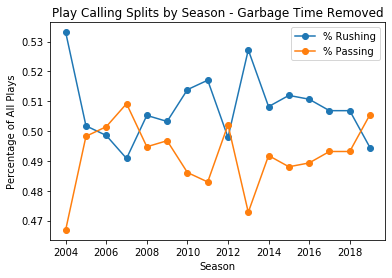

In [6]:
# create figure
fig, ax = plt.subplots()

# create plots for rushingPct & passingPct by season
rushingPct, = ax.plot(playsBySeason.index, playsBySeason["rushingPct"], marker = "o")
passingPct, = ax.plot(playsBySeason.index, playsBySeason["passingPct"], marker = "o")

# set labels, title
ax.set_title("Play Calling Splits by Season - Garbage Time Removed")
ax.set_xlabel("Season")
ax.set_ylabel("Percentage of All Plays")

# add legend
ax.legend([rushingPct, passingPct], ["% Rushing", "% Passing"])

# save figure
plt.savefig('Figures/seasonPlayCallSplits-GT')

# show plot
plt.show()

#### Play Call Splits & Win %

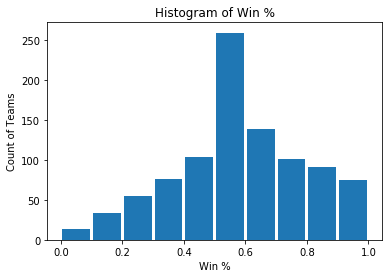

In [7]:
# Create column for win %
playCallsClean["winPct"] = playCallsClean["wins"] / playCallsClean["games"]

# plot histogram of Win %
plt.hist(playCallsClean["winPct"], 10, rwidth = 0.9)

# add title, labels
plt.title("Histogram of Win %")
plt.xlabel("Win %")
plt.ylabel("Count of Teams")

# show plot
plt.show()

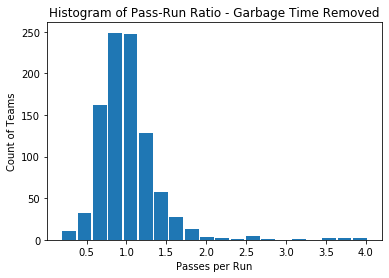

In [8]:
# create column for pass-run ratio
playCallsClean["passRunRatio"] = playCallsClean["passingPlays"] / playCallsClean["rushingPlays"]

# plot histogram of passRunRatio
plt.hist(playCallsClean["passRunRatio"], 20, rwidth = 0.9)

# add title, labels
plt.title("Histogram of Pass-Run Ratio - Garbage Time Removed")
plt.xlabel("Passes per Run")
plt.ylabel("Count of Teams")

# save figure
plt.savefig('Figures/passRunHist-GT')

# show plot
plt.show()

In [9]:
# Scale play totals to number of games
playCallsClean["playsPerGame"] = playCallsClean["totalPlays"] / playCallsClean["games"]

# Create column for pass/run ratio
playCallsClean["passRunRatio"] = playCallsClean["passingPlays"] / playCallsClean["rushingPlays"]

# regress Plays per Game against Win %
x_values = playCallsClean["passRunRatio"]
y_values = playCallsClean["winPct"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

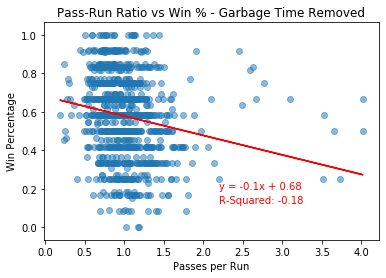

In [10]:
# plot passRunRatio against win %
plt.scatter(playCallsClean["passRunRatio"], playCallsClean["winPct"], alpha = 0.5)

# plot regression line & labels
plt.plot(x_values, regress_values, color = "red")
plt.annotate(line_eq, (2.2, 0.2), fontsize = 10, color = "red")
plt.annotate(f"R-Squared: {round(rvalue, 2)}", (2.2, 0.125), fontsize = 10, color = "red")

# add title, labels
plt.title("Pass-Run Ratio vs Win % - Garbage Time Removed")
plt.xlabel("Passes per Run")
plt.ylabel("Win Percentage")

# show plot
plt.show()

In [11]:
# recreate plot removing teams with more than 2 passes per run / 2 runs per pass
plot_subset = playCallsClean.loc[playCallsClean["passRunRatio"] <= 2]
plot_subset = plot_subset.loc[plot_subset["passRunRatio"] >= 0.5]

# regress passRunRatio against Win %
x_values = plot_subset["passRunRatio"]
y_values = plot_subset["winPct"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

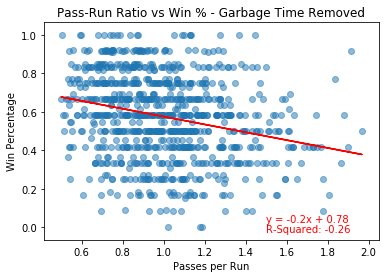

In [12]:
# plot passRunRatio against win %
plt.scatter(plot_subset["passRunRatio"], plot_subset["winPct"], alpha = 0.5)

# plot regression line & labels
plt.plot(x_values, regress_values, color = "red")
plt.annotate(line_eq, (1.5, 0.025), fontsize = 10, color = "red")
plt.annotate(f"R-Squared: {round(rvalue, 2)}", (1.5, -0.025), fontsize = 10, color = "red")

# add title & labels
plt.title("Pass-Run Ratio vs Win % - Garbage Time Removed")
plt.xlabel("Passes per Run")
plt.ylabel("Win Percentage")

# save figure
plt.savefig('Figures/passRun_winPct-GT')

# show plot
plt.show()